# Analysis of Graniteville Train Crash

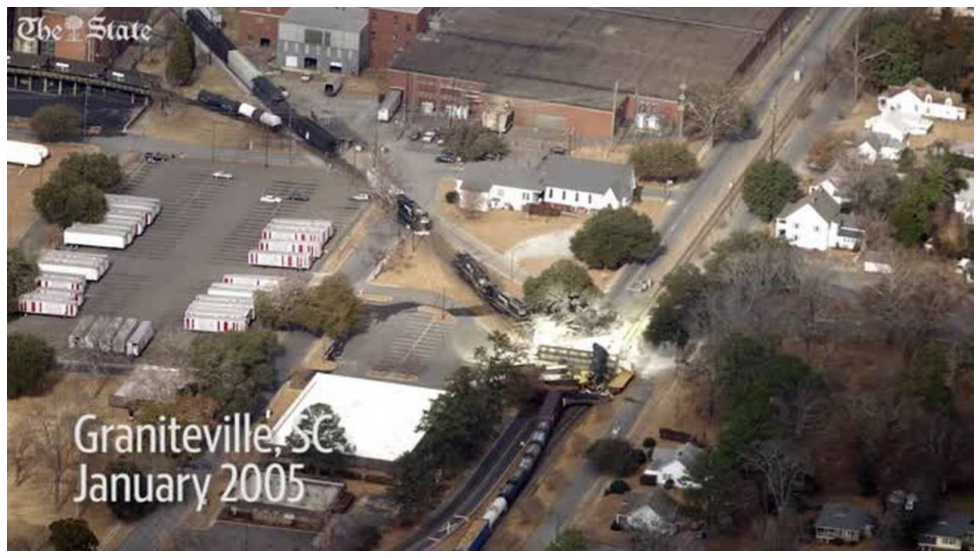

The Graniteville train crash was an American rail disaster that occurred on January 6, 2005,      in Graniteville, South Carolina. At roughly 2:40am EST, two Norfolk Southern trains collided      near the Avondale Mills plant in Graniteville.Nine people were killed and over 250 people were       treated for toxic chlorine exposure


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
from scipy.spatial import distance
import matplotlib.pyplot as plt
from PIL import  Image

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

%matplotlib inline

plt.figure(figsize=(20,10))
img = np.array(Image.open(r"D:\Sunny_Personal\OSU MSBA\SpecialCase\crash.jpg"))
plt.imshow(img,interpolation="bilinear")
plt.axis("off")
plt.show()

print('The Graniteville train crash was an American rail disaster that occurred on January 6, 2005,\
      in Graniteville, South Carolina. At roughly 2:40am EST, two Norfolk Southern trains collided\
      near the Avondale Mills plant in Graniteville.Nine people were killed and over 250 people were \
      treated for toxic chlorine exposure')

# Importing the Patients, chemicals and the actual answers dataset

In [2]:
os.chdir('D:\Sunny_Personal\OSU MSBA\SpecialCase')

#importing the chemicals dataset containing 311 unique chemicals with 79 symptoms 
chemicals=pd.read_csv('UniqueChemData_new.csv')
print('The shape of chemicals dataset is '+str(chemicals.shape))

#importing the patients dataset containing 1.1 million patients with 79 symptoms
patients=pd.read_csv('CasePatientData_new.csv')
print('The shape of patients dataset is '+str(patients.shape))

#importing the right chemical the patient is exposed to
actual_answers=pd.read_csv('ActualAnswers.csv')

#Concatenating the patients dataset with the actual chemical exposed to that patient
final_data=pd.concat([patients,actual_answers],axis=1)
print('The shape of final concatenated dataset is '+str(final_data.shape))

The shape of chemicals dataset is (311, 80)
The shape of patients dataset is (1010000, 79)
The shape of final concatenated dataset is (1010000, 80)


# Predicting the right chemical the patients are exposed to 

### The Similarity measures for discrete variables are
* Hamming Distance
* Simple Matching coefficients
* Jacard's coefficients

**1. Hamming Distance(XOR)**

In order to calculate the Hamming distance between two strings, and , we perform their XOR operation, (a⊕ b), and then count the total number of 1s in the resultant string.

**2. Simple Matching coefficients (XNOR)** 

 \begin{aligned}{\text{Simple Matching Coefficients(SMC)}}&={\frac {\text{number of matching attributes}}{\text{number of attributes}}}\\[8pt]&={\frac {M_{00}+M_{11}}{M_{00}+M_{01}+M_{10}+M_{11}}}\end{aligned}

M11 is the total number of attributes where A and B both have a value of 1 \
M01 is the total number of attributes where the attribute of A is 0 and the attribute of B is 1 \
M10 is the total number of attributes where the attribute of A is 1 and the attribute of B is 0 \
M00 is the total number of attributes where A and B both have a value of 0 


**3. Jacard's coefficients**

 \begin{aligned}{\text{Jacard's coefficients}}&={\frac {\text{number of matching attributes}}{\text{number of attributes}}}\\[8pt]&={\frac {M_{11}}{M_{01}+M_{10}+M_{11}}}\end{aligned}



**Difference between SMC and Jaccard index** 

The main difference is that the SMC has the term M00 in its numerator and denominator, whereas the Jaccard index does not. Thus, the SMC counts both mutual presences (when an attribute is present in both sets) and mutual absence (when an attribute is absent in both sets) as matches and compares it to the total number of attributes in the universe, whereas the Jaccard index only counts mutual presence as matches and compares it to the number of attributes that have been chosen by at least one of the two sets.

In market basket analysis, for example, the basket of two consumers who we wish to compare might only contain a small fraction of all the available products in the store, so the SMC will usually return very high values of similarities even when the baskets bear very little resemblance, thus making the Jaccard index a more appropriate measure of similarity in that context. For example, consider a supermarket with 1000 products and two customers. The basket of the first customer contains salt and pepper and the basket of the second contains salt and sugar. In this scenario, the similarity between the two baskets as measured by the Jaccard index would be 1/3, but the similarity becomes 0.998 using the SMC.


**In our case, 0s are equally important as 1s. Therefore, Simple Matching coefficients
can be used to find the similarity. Eucledian Distance can also be used to find out the similarity but it is generally recommended for continuous variables** 

In [4]:

#Dropping the chemical name to allow the Eucledian distance calculation
chemicals_upd=chemicals[chemicals.columns[~chemicals.columns.isin(['Unnamed: 0'])]]

#Calculating eucledian distance between a patient and all the chemicals 
#Minimum the distance, more the similarity
#Took the index of the chemical with minimum distance

#Eucledian distance
index=np.argmin(euclidean_distances(patients,chemicals_upd),axis=1)

#Simple Matching Coefficient
#index=np.argmin(np.logical_xor(patients,chemicals_upd))

#Converting Index array into a pandas dataframe
Final_DF=pd.DataFrame(index,columns=['Predicted_chemical_ID'])

#Incrementing the index to match the right affected chemical ID
Final_DF['Predicted_chemical_ID']=Final_DF['Predicted_chemical_ID']+1

#Creating a column of the actual answers
Final_DF['Actual_chemical_ID']=actual_answers['chemical_ID'].values.tolist()

#Calculating the accuracy by counting the matches
no_of_matches=Final_DF[Final_DF['Predicted_chemical_ID']==Final_DF['Actual_chemical_ID']].count()[1]
total_count=Final_DF.count()[1]
accuracy=np.round((no_of_matches/total_count)*100,2)
print("Accuracy of the matching is "+str(accuracy) +'%')

Accuracy of the matching is 97.13%


# Minimum symptoms required to find out the chemical the patient is exposed to, maintaining 80% accuracy

### Calculating chemical frequency in the patients dataset

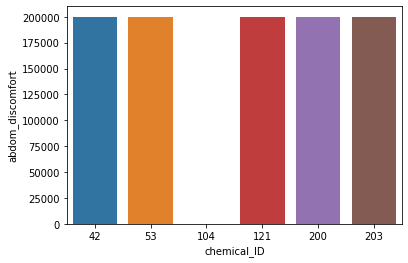

In [5]:
frequent_occc_chemicals=final_data.groupby(['chemical_ID']).count().sort_values(by='abdom_discomfort',ascending=False)
frequent_occc_chemicals.reset_index(inplace=True)
frequent_occc_chemicals_sel=frequent_occc_chemicals[['chemical_ID','abdom_discomfort']]

#plotting barchart
sns.barplot(y='abdom_discomfort',x='chemical_ID',data=frequent_occc_chemicals_sel[:6])
plt.show()

###  Down Sampling the data to make  the analysis generalized

In [35]:
from random import sample 
final_42_53_121_200_203=pd.DataFrame()
for i in [42,53,121,200,203]:
        dataset=str('chemical_')+str(i)
        globals()[str('chemical_')+str(i)]=final_data[final_data['chemical_ID']==i].sample(n=50)
        
final_42_53_121_200_203=pd.concat([chemical_42,chemical_53,chemical_121,chemical_200,chemical_203])

#all the information of patients except of those exposed to 42,53,121,200,203
final_data_rest=final_data[~final_data['chemical_ID'].isin([42,53,121,200,203])]

#random sample of 50 patient records for each of those 5 chemicals
final_42_53_121_200_203.head(1)

#merge both the dataframes
sample_df=pd.concat([final_data_rest,final_42_53_121_200_203])
sample_df.head()

#dropping chemical name and creating a df
downsampled_df=sample_df.drop(columns=['chemical_ID'])

##  Random Forest
    
       * Train a model using Random Forest classifier on the chemicals dataset 
           (311 chemicals and 79 symptoms)
         
       * Fitting a model on the down-sampled dataset using different set of important variables
       
       * Choosing minimum set of predictors ( minimum symptoms ) by finding a model with minimum 
         80% accuracy


### 1. Train a model using Random Forest classifier on the chemicals dataset 

In [143]:
#Importing Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
print('Libraries Imported')

#Dropping the chemical name from the chemicals dataset
chemicals.rename(columns={'Unnamed: 0':'chemical'},inplace=True)

#Creating the dependent variable class
factor = pd.factorize(chemicals['chemical'])
chemicals.chemical = factor[0]
definitions = factor[1]

#Splitting the data into independent and dependent variables
X = chemicals.iloc[:,1:].values
y = chemicals.iloc[:,0].values

# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X, y)

Libraries Imported


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### 2. Extracting the most important variables from the random forest classifier

#### Function to calculate the eucledian distance metric and accuracy in the predictions

In [226]:
def eucledian_distance(patients_array_sample,chemicals_array,type_df):
    
    #Calculating eucledian distance between a patient and all the chemicals 
    #Minimum the distance, more the similarity
    #Took the index of the chemical with minimum distance

    index=np.argmin(euclidean_distances(patients_array_sample,chemicals_array),axis=1)

    #Converting Index array into a pandas dataframe
    Final_DF=pd.DataFrame(index,columns=['Predicted_chemical_ID'])

    #Incrementing the index to match the right affected chemical ID
    Final_DF['Predicted_chemical_ID']=Final_DF['Predicted_chemical_ID']+1

    if (type_df=='overall'):
        #Creating a column of the actual answers
        Final_DF['Actual_chemical_ID']=actual_answers['chemical_ID'].values.tolist()
    else:
        #Creating a column of the actual answers
        Final_DF['Actual_chemical_ID']=sample_df['chemical_ID'].values.tolist()
    
    #Caluclating the accuracy by counting the matches
    no_of_matches=Final_DF[Final_DF['Predicted_chemical_ID']==Final_DF['Actual_chemical_ID']].count()[1]
    total_count=Final_DF.count()[1]
    accuracy=np.round(((no_of_matches/total_count)*100),2)
    #print("Accuracy of the matching is "+str(accuracy))
    
    return accuracy

#### Function to calculate the accuracy between the sample and patients dataset

In [236]:
def accuracy_calculation(selected_variables):# Sample Patients data set
    
    #downsample dataframe
    total_columns_list=sample_df.columns.to_list()
    To_keep_variables=[i for i in total_columns_list if i in selected_variables]
    patients_selected=sample_df[To_keep_variables]
    patients_array_sample_ds=np.array(patients_selected)
    
    #Patients data set
    total_columns_list=patients.columns.to_list()
    To_keep_variables=[i for i in total_columns_list if i in selected_variables]
    patients_selected=patients[To_keep_variables]
    patients_array_sample=np.array(patients_selected)
    patients_array_sample.shape

    #chemicals data set
    total_columns_list=chemicals.columns.to_list()
    To_keep_variables=[i for i in total_columns_list if i in selected_variables]
    chemicals_selected=chemicals[To_keep_variables]
    chemicals_array=np.array(chemicals_selected)
    chemicals_array.shape
    
    sample_accuracy=eucledian_distance(patients_array_sample_ds,chemicals_array,'sample')
    overall_accuracy=eucledian_distance(patients_array_sample,chemicals_array,'overall')
    
    return sample_accuracy, overall_accuracy

In [228]:
import pandas as pd
# Extract feature importances
feature_importance_random_Forest = pd.DataFrame({'feature': list(chemicals_symptoms.columns),
                   'importance': classifier.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [246]:
#To find the sweetspot between the accuracy and number of predictors required

predictors_accuracy=[]

for i in range(len(feature_importance_random_Forest)):
    selected_variables=feature_importance_random_Forest[:i+1]['feature'].values
    [sample_accuracy,overall_accuracy]=accuracy_calculation(selected_variables)
    predictors_accuracy.append([i,sample_accuracy,overall_accuracy])
   
Accuracies_df=pd.DataFrame(predictors_accuracy,columns=['Number_of_variables','Down_sample_accuracy','overall_accuracy'])

### Plotting the accuracies between the Sample and the overall data

C:\Users\Harish Patlolla\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


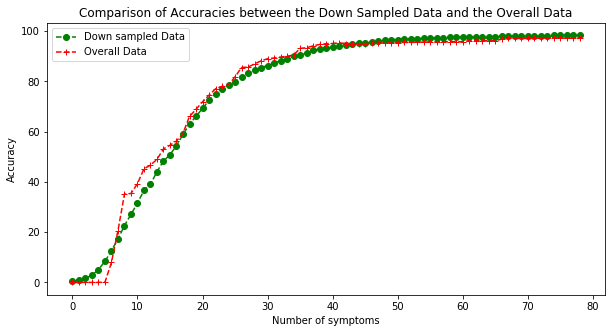

To obtain a minimum accuracy of 80% in both the data , the number of symptoms to choose are 26


In [281]:
fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)

ax.plot(Accuracies_df['Number_of_variables'],Accuracies_df['Down_sample_accuracy'],c='g',marker="o",ls='--',label='Down sampled Data')
ax.plot(Accuracies_df['Number_of_variables'],Accuracies_df['overall_accuracy'],c='r',marker="+",ls='--',label='Overall Data')
plt.xlabel('Number of symptoms')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracies between the Down Sampled Data and the Overall Data')
plt.legend(loc=2)
plt.show()

print('To obtain a minimum accuracy of 80% in both the data , the number of symptoms to choose are 26')

In [298]:
print('The minimum Symptoms to predict with 80% Accuracy are ')
print(' ')
print(feature_importance_random_Forest[:25]['feature'])

The minimum Symptoms to predict with 80% Accuracy are 
 
68    tearing                     
6     bradycardia                 
15    diarrhea                    
19    drowsiness                  
9     chest_pain                  
4     blistering                  
75    vision_loss                 
14    cyanosis_blue               
57    shivering                   
53    respiratory_coughing_choking
17    dizziness                   
56    runny_nose                  
23    eye_swelling                
63    slow_breathing              
11    congestion                  
8     chest_discomfort            
52    respiratory_arrest          
18    drooling_salivation         
65    spasms_seizures             
29    hypertension                
74    urination_bloody            
30    hypotension_shock           
2     agitation                   
35    lack_of_coordination        
44    nose_sneezing               
Name: feature, dtype: object
